In [562]:
#imports
import pulp as p
from pulp import value
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [628]:
# Pickle-Datei laden
df_2019 = pd.read_pickle('daten.pkl')
df = df_2019

anschaffungskosten_speicher = 6000
anschaffunskosten_pumpe = 7800
jahresrechnung_heizkosten_vor_pumpe = 2370


In [695]:
# Anzahl der Tage die betrachet werden sollen
weeks = 52
T = int(len(df['Strompreis']))

p_max = 10
s_max = 7
s_laden = 3
s_entladen = 1

dt = 1  # Stunde
B_start = 0  # Anfangsfüllstand des Wärmespeichers

U_wand = 0.3  # Wärmedurchgangskoeffizient Wand (W/m²K)
A_wand = 50   # Fläche der Wand (m²)
U_fenster = 1.2  # Wärmedurchgangskoeffizient Fenster (W/m²K)
A_fenster = 10   # Fläche der Fenster (m²)
V_raum = 180     # Raumvolumen (m³)
luftwechselrate = 0.5  # Luftwechselrate (1/h)
rho = 1.2        # Dichte der Luft (kg/m³)
c = 1000         # Wärmekapazität der Luft (J/kgK)
temp_innen = 20 # Gewünschte Innentemperatur in Grad
cop_vorfaktor = 0.4 #
a = 1.5  # Steigung Heizkurve
b = 30  # Basiswert

P_bat = 10 # Maximale Lade- & Entladeleistung Batterie in kW
E_bat = 20 # Maximale Kapazität Batterie in kW
eta_bat = 0.9
c_pur = 0.2  # Strompreis in EUR/kWh
c_feedin = 0.0  # Einspeisevergütung EUR/kWh Einspeisen
l_start = 0  # Anfangsfüllstand der Batterie in kW

In [696]:
# Beispielhafte Parameterdefinitionen

# Außentemperaturen (°C) für jede Stunde
T_außen = df_2019['Geschätzte Temperatur'].values

# Strompreise
Strompreise = df_2019['Strompreis'].values

# Elektrische Nachfrage des Haushalts ohne Wärmepumpe (kW) für jede Stunde
D_Haushalt = df_2019['demand'].values

# Berechnung der PV-Erzeugung (kW)
PV = df_2019['pv'].values

# Temperaturunterschied
delta_T = temp_innen - T_außen # Temperaturdifferenz innen/außen (K)

# Temperaturunterschied
# Negative Werte durch 0 ersetzen
delta_T = np.maximum(delta_T, 0)

# Transmissionswärmeverluste
Q_T_wand = U_wand * A_wand * delta_T
Q_T_fenster = U_fenster * A_fenster * delta_T
Q_T = Q_T_wand + Q_T_fenster

# Lüftungswärmeverluste
V_dot = V_raum * luftwechselrate / 3600  # Luftvolumenstrom (m³/s)
Q_L = V_dot * rho * c * delta_T / 1000  # in kW

# Gesamte Heizlast in kW pro Zeiteinheit
d = Q_T / 1000 + Q_L  # in kW

# Vorlauftemperatur berechnen
T_heating = [a * (temp_innen - temp) + b for temp in T_außen]

# Umrechnung Vorlauftemperatur & Außentemperatur in Kelvin
T_heating_K = np.array(T_heating) + 273.15
T_source_K = np.array(T_außen) + 273.15

# COP berechnen mit Sicherheitsprüfung gegen Nulldivision & Begrenzung für COP, da durch sehr kleine Werte dividiert werden kann
COP = []
for heating, source in zip(T_heating_K, T_source_K):
    if heating > source:
        cop = heating / (heating - source) * cop_vorfaktor
        if cop < 4.5:
            COP.append(cop)
        else:
            cop = 4.5
            COP.append(cop)
    else:
        cop = 4.5
        COP.append(cop)

# Heizkosten pro kW Wärme (EUR/kW) für jede Stunde
c_t = [strompreis / cop for strompreis, cop in zip(Strompreise, COP)]

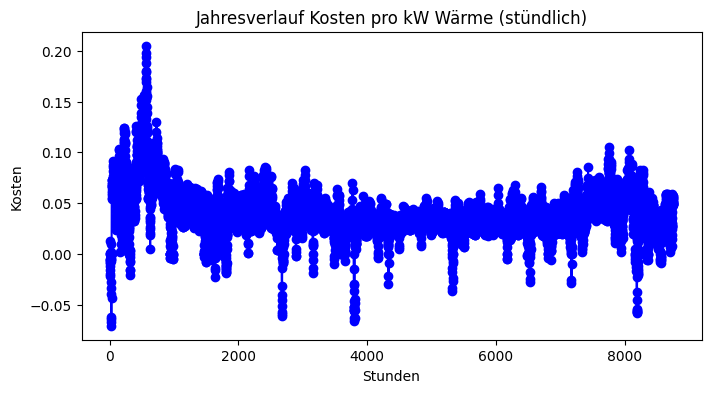

In [697]:
plt.figure(figsize=(8, 4))
plt.plot(c_t, marker='o', linestyle='-', color='blue', label='COP')

# Beschriftungen
plt.xlabel('Stunden')       # Passe die Einheit an, z.B. Sekunden, Minuten, etc.
plt.ylabel('Kosten')
plt.title('Jahresverlauf Kosten pro kW Wärme (stündlich)')

# Diagramm anzeigen
plt.show()

In [698]:
# Variablen & Nebenbedingungen

# Erzeugt die Wärmepumpenvariable und fügt Grenzen hinzu
P = [p.LpVariable(f"p_{t}", lowBound=0, upBound=p_max) for t in range(T)]

# Erzeugt die Variable für den thermischen Speicherfüllstand und fügt Grenzen hinzu
B = [p.LpVariable(f"B_{t}", lowBound=0, upBound=s_max) for t in range(T)]

# Erzeugt die Ladevariable und fügt Grenzen hinzu
x_in = [p.LpVariable(f"x_in_{t}", lowBound=0, upBound=s_laden) for t in range(T)]

# Erzeugt die Entladevariable und fügt Grenzen hinzu
x_out = [p.LpVariable(f"x_out_{t}", lowBound=0, upBound=s_entladen) for t in range(T)]

In [699]:
# Komplexere Nebenbedingungen

constraints = []

# Deckung des Wärmebedarfs
for t in range(T):
    constraints.append(d[t] == P[t] + x_out[t] - x_in[t])

# Dynamik des Speicherfüllstands
for t in range(T-1):
    constraints.append(B[t+1] == B[t] + x_in[t] - x_out[t])

# Anfangsfüllstand des Wärmespeichers
constraints.append(B[0] == B_start + x_in[0] - x_out[0])

# Speichert Constraints für Modell Integration
merged_constraints = constraints

In [700]:
# Zielfunktion
objective = p.lpSum([c_t[t] * P[t] for t in range(T)])

In [701]:
# Erstelle das Optimierungsproblem
model_1 = p.LpProblem("Energieoptimierung", p.LpMinimize)

# Füge die Zielfunktion hinzu
model_1 += objective

# Füge alle Nebenbedingungen hinzu
for constraint in constraints:
    model_1 += constraint

# Löse das Problem
model_1.solve()

# Status des Modells abfragen
status = p.LpStatus[model_1.status]

# If-Anweisung basierend auf dem Status
if status == "Optimal":
    # Ergebnisse anzeigen
    for t in range(T):
        print(f"Wärmeleistung P_{t}: {P[t].varValue}")
        print(f"Speicherfüllstand B_{t}: {B[t].varValue}")
        print(f"Ladeleistung x_in_{t}: {x_in[t].varValue}")
        print(f"Entladeleistung x_out_{t}: {x_out[t].varValue}")
        print("-" * 30)
    print("Status:", p.LpStatus[model_1.status])
    print(f"Kosten:", round(p.value(model_1.objective), 2), "€")
elif status == "Infeasible":
    print("Das Modell ist unlösbar. Es gibt keine Lösung, die alle Nebenbedingungen erfüllt. Bitte überprüfung Sie ihre Eingaben!")
else:
    print("Error, bitte kontaktieren Sie den Support!")

Wärmeleistung P_0: 0.8488301
Speicherfüllstand B_0: 0.0
Ladeleistung x_in_0: 0.0
Entladeleistung x_out_0: 0.0
------------------------------
Wärmeleistung P_1: 0.87495
Speicherfüllstand B_1: 0.0
Ladeleistung x_in_1: 0.0
Entladeleistung x_out_1: 0.0
------------------------------
Wärmeleistung P_2: 1.8119702
Speicherfüllstand B_2: 0.0
Ladeleistung x_in_2: 0.91459055
Entladeleistung x_out_2: 0.0
------------------------------
Wärmeleistung P_3: 0.0
Speicherfüllstand B_3: 0.91459055
Ladeleistung x_in_3: 0.0
Entladeleistung x_out_3: 0.91459055
------------------------------
Wärmeleistung P_4: 1.9254098
Speicherfüllstand B_4: 0.0
Ladeleistung x_in_4: 1.0
Entladeleistung x_out_4: 0.0
------------------------------
Wärmeleistung P_5: 3.9291
Speicherfüllstand B_5: 1.0
Ladeleistung x_in_5: 3.0
Entladeleistung x_out_5: 0.0
------------------------------
Wärmeleistung P_6: 3.9254098
Speicherfüllstand B_6: 4.0
Ladeleistung x_in_6: 3.0
Entladeleistung x_out_6: 0.0
------------------------------
Wär

Zeit 450:
  Wärmeleistung P_450: 0.9529978
  Speicherfüllstand B_450: 0.0
  Ladeleistung x_in_450: 0.0
  Entladeleistung x_out_450: 0.0

Zeit 451:
  Wärmeleistung P_451: 0.97292793
  Speicherfüllstand B_451: 0.0
  Ladeleistung x_in_451: 0.0
  Entladeleistung x_out_451: 0.0

Zeit 452:
  Wärmeleistung P_452: 4.0046322
  Speicherfüllstand B_452: 0.0
  Ladeleistung x_in_452: 3.0
  Entladeleistung x_out_452: 0.0

Zeit 453:
  Wärmeleistung P_453: 0.04595
  Speicherfüllstand B_453: 3.0
  Ladeleistung x_in_453: 0.0
  Entladeleistung x_out_453: 1.0

Zeit 454:
  Wärmeleistung P_454: 3.0940656
  Speicherfüllstand B_454: 2.0
  Ladeleistung x_in_454: 2.0
  Entladeleistung x_out_454: 0.0

Zeit 455:
  Wärmeleistung P_455: 4.1457
  Speicherfüllstand B_455: 4.0
  Ladeleistung x_in_455: 3.0
  Entladeleistung x_out_455: 0.0

Zeit 456:
  Wärmeleistung P_456: 1.275022
  Speicherfüllstand B_456: 7.0
  Ladeleistung x_in_456: 0.0
  Entladeleistung x_out_456: 0.0

Zeit 457:
  Wärmeleistung P_457: 1.323825
  Sp

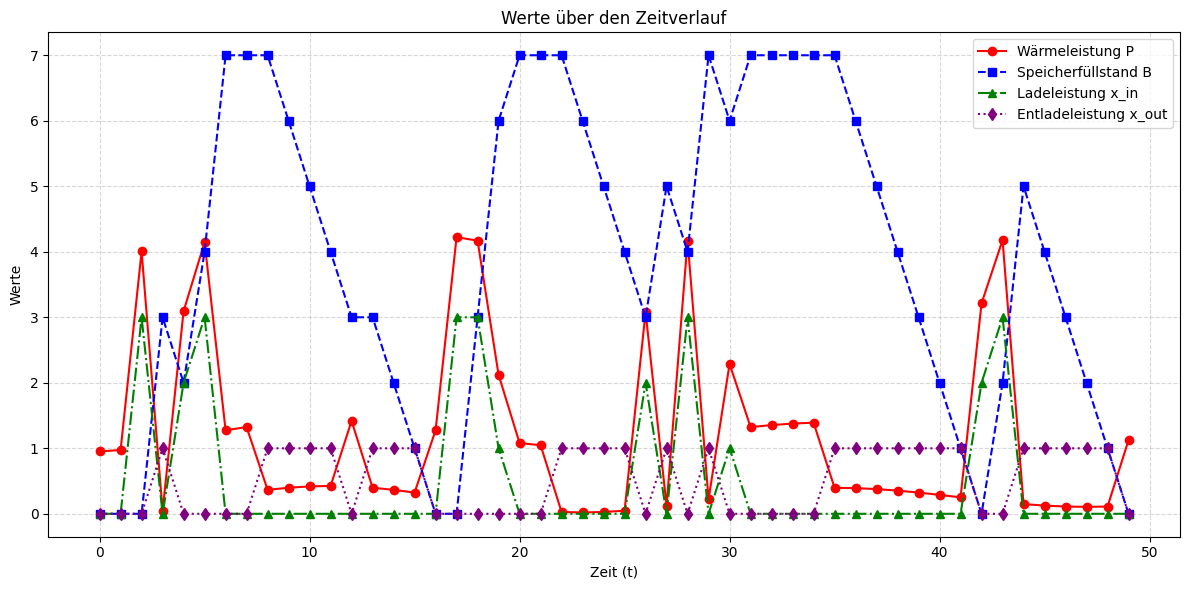

In [702]:
# Listen zur Speicherung der Werte
P_values = []
B_values = []
x_in_values = []
x_out_values = []
time_steps = list(range(50))

# Werte extrahieren
for t in range(450,500):
    P_values.append(P[t].varValue)
    B_values.append(B[t].varValue)
    x_in_values.append(x_in[t].varValue)
    x_out_values.append(x_out[t].varValue)

    # Optional: Ausgabe in der Konsole
    print(f"Zeit {t}:")
    print(f"  Wärmeleistung P_{t}: {P[t].varValue}")
    print(f"  Speicherfüllstand B_{t}: {B[t].varValue}")
    print(f"  Ladeleistung x_in_{t}: {x_in[t].varValue}")
    print(f"  Entladeleistung x_out_{t}: {x_out[t].varValue}\n")

# Plot erstellen
plt.figure(figsize=(12, 6))

plt.plot(time_steps, P_values, marker='o', linestyle='-', color='red', label='Wärmeleistung P')
plt.plot(time_steps, B_values, marker='s', linestyle='--', color='blue', label='Speicherfüllstand B')
plt.plot(time_steps, x_in_values, marker='^', linestyle='-.', color='green', label='Ladeleistung x_in')
plt.plot(time_steps, x_out_values, marker='d', linestyle=':', color='purple', label='Entladeleistung x_out')

# Achsenbeschriftungen und Titel
plt.xlabel('Zeit (t)')
plt.ylabel('Werte')
plt.title('Werte über den Zeitverlauf')

# Legende
plt.legend()

# Gitter hinzufügen für bessere Lesbarkeit
plt.grid(True, linestyle='--', alpha=0.5)

# Diagramm anzeigen
plt.tight_layout()
plt.show()

In [703]:
# Variablen & Nebenbedingungen

# Erzeugt Variable für den Strombezug aus dem Netz und fügt untere Grenze hinzu
y_pur = [p.LpVariable(f"y_pur_{t}", lowBound=0) for t in range(T)]

# Erzeugt Variable für die PV-Eigennutzungsvariable und fügt untere Grenze hinzu
y_pv_self = [p.LpVariable(f"y_pv_self_{t}", lowBound=0) for t in range(T)]

# Erzeugt Variable für die PV-Einspeisungsvariable und fügt untere Grenze hinzu
y_pv_feedin = [p.LpVariable(f"y_pv_feedin_{t}", lowBound=0) for t in range(T)]

# Erzeugt Variable für die Batterieladung und fügt Grenzen hinzu
y_s_ch = [p.LpVariable(f"y_s_ch_{t}", lowBound=0, upBound=P_bat) for t in range(T)]

# Erzeugt Variable für die Batterientladung und fügt Grenzen hinzu
y_s_dc = [p.LpVariable(f"y_s_dc_{t}", lowBound=0, upBound=P_bat) for t in range(T)]

# Erzeugt Variable für den Batteriefüllstand und fügt Grenzen hinzu
l_s = [p.LpVariable(f"l_s_{t}", lowBound=0, upBound=E_bat) for t in range(T)]

In [704]:
# Zielfunktion
cost_grid = p.lpSum([y_pur[t] * c_pur * dt for t in range(T)])
revenue_pv = p.lpSum([y_pv_feedin[t] * c_feedin * dt for t in range(T)])

objective = p.lpSum([cost_grid, -revenue_pv])

In [705]:
# Liste für aller sonstigen Nebenbedingungen
merged_constraints_1 = merged_constraints.copy()

constraints = []

# Deckung der elektrischen Nachfrage
for t in range(T):
    constraints.append(y_pur[t] + y_pv_self[t] + y_s_dc[t] - y_s_ch[t] == D_Haushalt[t])

# Dynamik des Batterie-Füllstands
for t in range(T-1):
    constraints.append(l_s[t+1] == l_s[t] + y_s_ch[t] * eta_bat * dt - y_s_dc[t] * dt)

# Anfangsfüllstand der Batterie
constraints.append(l_s[0] == l_start)

# Speichert Constraints für Modell Integration
merged_constraints_1.extend(constraints)

# Nebenbedingung, die sich im Gesamtmodell ändert, darf dementsprechend nur zum Basismodell hinzugefügt werden
for t in range(T):
    # Aufteilung der PV-Erzeugung
    constraints.append(y_pv_self[t] + y_pv_feedin[t] == PV[t])

In [706]:
# Erstelle das Optimierungsproblem
model_2 = p.LpProblem("Energieoptimierung", p.LpMinimize)

# Füge die Zielfunktion hinzu
model_2 += objective

# Füge alle Nebenbedingungen hinzu
for constraint in constraints:
    model_2 += constraint

# Löse das Problem
model_2.solve()

# Ergebnisse anzeigen
for t in range(T):
    print(f"Strombezug aus dem Netz y_pur_{t}: {y_pur[t].varValue}")
    print(f"PV-Eigennutzung y_pv_self_{t}: {y_pv_self[t].varValue}")
    print(f"PV-Einspeisung y_pv_feedin_{t}: {y_pv_feedin[t].varValue}")
    print(f"Batterieladung y_s_ch_{t}: {y_s_ch[t].varValue}")
    print(f"Batterientladung y_s_dc_{t}: {y_s_dc[t].varValue}")
    print(f"Batteriefüllstand l_s_{t}: {l_s[t].varValue}")
    print("----------------------")
print("Status:", p.LpStatus[model_2.status])
print("Minimale Kosten:", p.value(model_2.objective))

Strombezug aus dem Netz y_pur_0: 0.17522049
PV-Eigennutzung y_pv_self_0: 0.0
PV-Einspeisung y_pv_feedin_0: 0.0
Batterieladung y_s_ch_0: 0.0
Batterientladung y_s_dc_0: 0.0
Batteriefüllstand l_s_0: 0.0
----------------------
Strombezug aus dem Netz y_pur_1: 0.12966497
PV-Eigennutzung y_pv_self_1: 0.0
PV-Einspeisung y_pv_feedin_1: 0.0
Batterieladung y_s_ch_1: 0.0
Batterientladung y_s_dc_1: 0.0
Batteriefüllstand l_s_1: 0.0
----------------------
Strombezug aus dem Netz y_pur_2: 0.11884703
PV-Eigennutzung y_pv_self_2: 0.0
PV-Einspeisung y_pv_feedin_2: 0.0
Batterieladung y_s_ch_2: 0.0
Batterientladung y_s_dc_2: 0.0
Batteriefüllstand l_s_2: 0.0
----------------------
Strombezug aus dem Netz y_pur_3: 0.11572185
PV-Eigennutzung y_pv_self_3: 0.0
PV-Einspeisung y_pv_feedin_3: 0.0
Batterieladung y_s_ch_3: 0.0
Batterientladung y_s_dc_3: 0.0
Batteriefüllstand l_s_3: 0.0
----------------------
Strombezug aus dem Netz y_pur_4: 0.11758494
PV-Eigennutzung y_pv_self_4: 0.0
PV-Einspeisung y_pv_feedin_4: 0

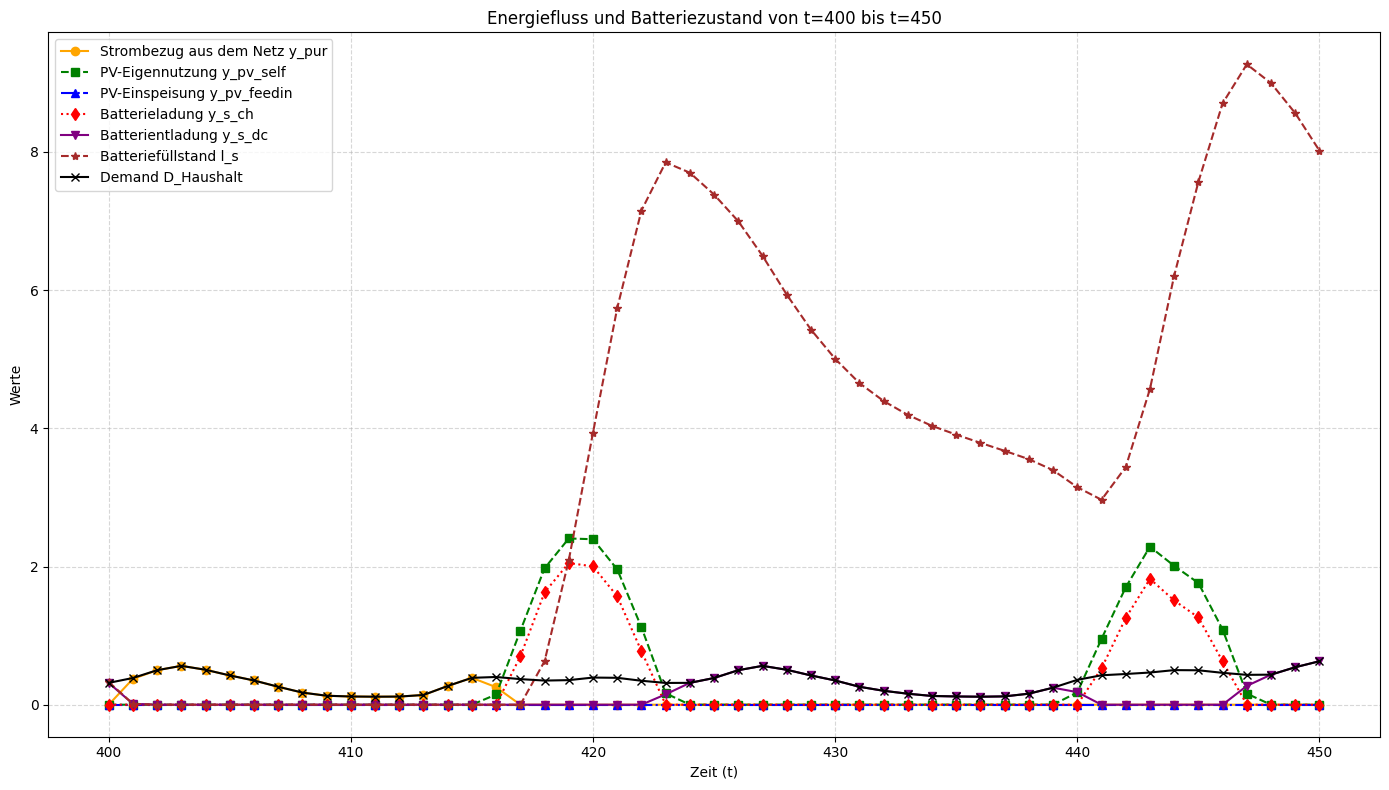

In [707]:
# Werte extrahieren
y_pur_values = [y_pur[t].varValue for t in range(T)]
y_pv_self_values = [y_pv_self[t].varValue for t in range(T)]
y_pv_feedin_values = [y_pv_feedin[t].varValue for t in range(T)]
y_s_ch_values = [y_s_ch[t].varValue for t in range(T)]
y_s_dc_values = [y_s_dc[t].varValue for t in range(T)]
l_s_values = [l_s[t].varValue for t in range(T)]
time_steps = list(range(T))

# Definiere den Bereich, den du plotten möchtest
start_t = 400
end_t = 450

# Überprüfen, ob der Bereich innerhalb der Daten liegt
if end_t >= T:
    raise ValueError(f"Endzeitpunkt {end_t} überschreitet die maximale Zeitperiode {T-1}.")

# Slice die Daten für den gewünschten Bereich
sliced_time = time_steps[start_t:end_t+1]
sliced_y_pur = y_pur_values[start_t:end_t+1]
sliced_y_pv_self = y_pv_self_values[start_t:end_t+1]
sliced_y_pv_feedin = y_pv_feedin_values[start_t:end_t+1]
sliced_y_s_ch = y_s_ch_values[start_t:end_t+1]
sliced_y_s_dc = y_s_dc_values[start_t:end_t+1]
sliced_l_s = l_s_values[start_t:end_t+1]
sliced_demand = D_Haushalt[start_t:end_t+1]

# Plot erstellen
plt.figure(figsize=(14, 8))

# Strombezug aus dem Netz
plt.plot(sliced_time, sliced_y_pur, marker='o', linestyle='-', color='orange', label='Strombezug aus dem Netz y_pur')
# PV-Eigennutzung
plt.plot(sliced_time, sliced_y_pv_self, marker='s', linestyle='--', color='green', label='PV-Eigennutzung y_pv_self')
# PV-Einspeisung
plt.plot(sliced_time, sliced_y_pv_feedin, marker='^', linestyle='-.', color='blue', label='PV-Einspeisung y_pv_feedin')
# Batterieladung
plt.plot(sliced_time, sliced_y_s_ch, marker='d', linestyle=':', color='red', label='Batterieladung y_s_ch')
# Batterientladung
plt.plot(sliced_time, sliced_y_s_dc, marker='v', linestyle='-', color='purple', label='Batterientladung y_s_dc')
# Batteriefüllstand
plt.plot(sliced_time, sliced_l_s, marker='*', linestyle='--', color='brown', label='Batteriefüllstand l_s')
# Demand hinzufügen
plt.plot(sliced_time, sliced_demand, marker='x', linestyle='-', color='black', label='Demand D_Haushalt')

# Achsenbeschriftungen und Titel
plt.xlabel('Zeit (t)')
plt.ylabel('Werte')
plt.title(f'Energiefluss und Batteriezustand von t={start_t} bis t={end_t}')

# Legende
plt.legend()

# Gitter hinzufügen für bessere Lesbarkeit
plt.grid(True, linestyle='--', alpha=0.5)

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()

In [708]:
# Diese beiden Modelle lassen sich zunächst problemlos miteinander integrieren,
# da aufgrund der separaten Stromverträge kein Verhältnis/Kommunikation zwischen den beiden Systemen besteht,
# sodass sich die Modelle einzeln lösen lassen und die Kosten zum Schluss summiert werden können.

# Kosten beider Modelle werden addiert
print(f"Kosten Wärmepumpe-Modell :", round(p.value(model_1.objective), 2), "€")
print(f"Kosten Basismodell :", round(p.value(model_2.objective), 2), "€")
print(f"Gesamtkosten: ", round(p.value(model_1.objective + p.value(model_2.objective)), 2), "€")

# Ein separater Stromvertrag ist die gängige Variante zum Betrieb eine Wärmepumpe in Deutschland,
# jedoch bietet es sich an die Wärmepumpe mit der Energie aus der Batterie oder direkt aus der PV-Produktion zu betreiben.
# Damit werden neue Variablen & Nebenbedingungen benötigt, um die Kommunikation beider Modelle abzubilden.

Kosten Wärmepumpe-Modell : 155.34 €
Kosten Basismodell : 46.5 €
Gesamtkosten:  201.84 €


In [709]:
# Neue Variablen aus Kombination beider Modelle

# Erzeugt Variable für den Wärmepumpenstrombezug durch Batterie und fügt untere Grenze hinzu
y_heat_bat = [p.LpVariable(f"y_heat_bat_{t}", lowBound=0, upBound=B[t]) for t in range(T)]

# Erzeugt Variable für den Wärmepumpenstrombezug durch PV-Anlage und fügt untere Grenze hinzu
y_heat_pv = [p.LpVariable(f"y_heat_pv_{t}", lowBound=0, upBound=PV[t]) for t in range(T)]

y_heat_pur = [p.LpVariable(f"factor{t}", lowBound=0) for t in range(T)]

In [710]:
# Zielfunktion: Minimierung der Gesamtkosten
# Kosten der Wärmepumpe + Kosten für Strombezug - Einnahmen durch PV-Einspeisung

cost_grid = p.lpSum([y_pur[t] * c_pur * dt for t in range(T)])
revenue_pv = p.lpSum([y_pv_feedin[t] * c_feedin * dt for t in range(T)])
cost_pump = p.lpSum([c_t[t] * y_heat_pur[t] for t in range(T)])

objective = p.lpSum([cost_pump, cost_grid, -revenue_pv])

In [711]:
#Komplexere Nebenbedingungen (nicht nur obere und untere Begrenzungen)
merged_constraints_2 = merged_constraints_1.copy()

for t in range(T):
    merged_constraints_2.append(P[t] == y_heat_pur[t] + y_heat_bat[t] + y_heat_pv[t])

    # Aufteilung der PV-Erzeugung
    merged_constraints_2.append(y_pv_self[t] + y_pv_feedin[t] + y_heat_pv[t] == PV[t])



In [712]:
# Erstelle das Optimierungsproblem
model = p.LpProblem("Energieoptimierung", p.LpMinimize)

# Füge die Zielfunktion hinzu
model += objective

# Füge alle Nebenbedingungen hinzu
for constraint in merged_constraints_2:
    model += constraint

# Löse das Problem
model.solve()

# Ergebnisse anzeigen
for t in range(T):
    print(f"Batteriebezug der Wärmepumpe y_heat_bat_{t}: {y_heat_bat[t].varValue}")
    print(f"PV-Bezug der Wärmepumpe y_heat_pv_{t}: {y_heat_pv[t].varValue}")
    print(f"Stromanbieter-Bezug der Wärmepumpe y_heat_pur_{t}: {y_heat_pur[t].varValue}")
    print("-" * 30)
print("Status:", p.LpStatus[model.status])
print("Minimale Kosten:", p.value(model.objective))

Batteriebezug der Wärmepumpe y_heat_bat_0: 0.0
PV-Bezug der Wärmepumpe y_heat_pv_0: 0.0
Stromanbieter-Bezug der Wärmepumpe y_heat_pur_0: 0.8488301
------------------------------
Batteriebezug der Wärmepumpe y_heat_bat_1: 0.0
PV-Bezug der Wärmepumpe y_heat_pv_1: 0.0
Stromanbieter-Bezug der Wärmepumpe y_heat_pur_1: 0.87495
------------------------------
Batteriebezug der Wärmepumpe y_heat_bat_2: 0.0
PV-Bezug der Wärmepumpe y_heat_pv_2: 0.0
Stromanbieter-Bezug der Wärmepumpe y_heat_pur_2: 1.8119702
------------------------------
Batteriebezug der Wärmepumpe y_heat_bat_3: 0.0
PV-Bezug der Wärmepumpe y_heat_pv_3: 0.0
Stromanbieter-Bezug der Wärmepumpe y_heat_pur_3: 0.0
------------------------------
Batteriebezug der Wärmepumpe y_heat_bat_4: 0.0
PV-Bezug der Wärmepumpe y_heat_pv_4: 0.0
Stromanbieter-Bezug der Wärmepumpe y_heat_pur_4: 1.9254098
------------------------------
Batteriebezug der Wärmepumpe y_heat_bat_5: 0.0
PV-Bezug der Wärmepumpe y_heat_pv_5: 0.0
Stromanbieter-Bezug der Wärmep

Zeit 450:
  Wärmeleistung P_450: 0.9529978
  Speicherfüllstand B_450: 0.0
  Ladeleistung x_in_450: 0.0
  Entladeleistung x_out_450: 0.0

Zeit 451:
  Wärmeleistung P_451: 0.97292793
  Speicherfüllstand B_451: 0.0
  Ladeleistung x_in_451: 0.0
  Entladeleistung x_out_451: 0.0

Zeit 452:
  Wärmeleistung P_452: 4.0046322
  Speicherfüllstand B_452: 0.0
  Ladeleistung x_in_452: 3.0
  Entladeleistung x_out_452: 0.0

Zeit 453:
  Wärmeleistung P_453: 0.04595
  Speicherfüllstand B_453: 3.0
  Ladeleistung x_in_453: 0.0
  Entladeleistung x_out_453: 1.0

Zeit 454:
  Wärmeleistung P_454: 3.0940656
  Speicherfüllstand B_454: 2.0
  Ladeleistung x_in_454: 2.0
  Entladeleistung x_out_454: 0.0

Zeit 455:
  Wärmeleistung P_455: 4.1457
  Speicherfüllstand B_455: 4.0
  Ladeleistung x_in_455: 3.0
  Entladeleistung x_out_455: 0.0

Zeit 456:
  Wärmeleistung P_456: 1.275022
  Speicherfüllstand B_456: 7.0
  Ladeleistung x_in_456: 0.0
  Entladeleistung x_out_456: 0.0

Zeit 457:
  Wärmeleistung P_457: 1.323825
  Sp

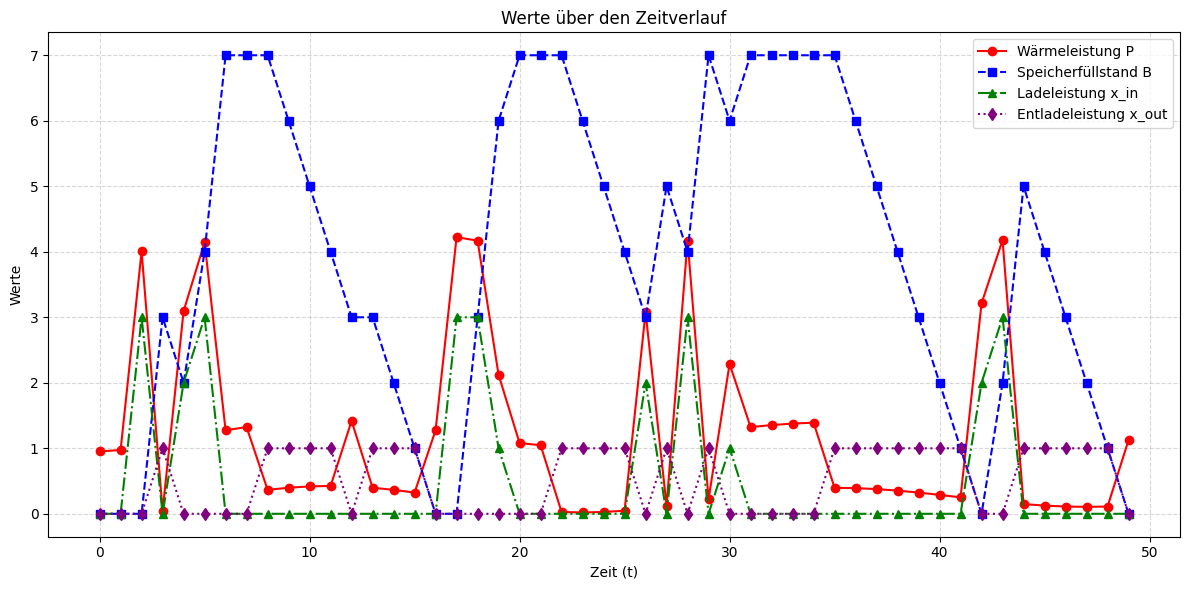

In [713]:
# Listen zur Speicherung der Werte
P_values = []
B_values = []
x_in_values = []
x_out_values = []
time_steps = list(range(50))

# Werte extrahieren
for t in range(450,500):
    P_values.append(P[t].varValue)
    B_values.append(B[t].varValue)
    x_in_values.append(x_in[t].varValue)
    x_out_values.append(x_out[t].varValue)

    # Optional: Ausgabe in der Konsole
    print(f"Zeit {t}:")
    print(f"  Wärmeleistung P_{t}: {P[t].varValue}")
    print(f"  Speicherfüllstand B_{t}: {B[t].varValue}")
    print(f"  Ladeleistung x_in_{t}: {x_in[t].varValue}")
    print(f"  Entladeleistung x_out_{t}: {x_out[t].varValue}\n")

# Plot erstellen
plt.figure(figsize=(12, 6))

plt.plot(time_steps, P_values, marker='o', linestyle='-', color='red', label='Wärmeleistung P')
plt.plot(time_steps, B_values, marker='s', linestyle='--', color='blue', label='Speicherfüllstand B')
plt.plot(time_steps, x_in_values, marker='^', linestyle='-.', color='green', label='Ladeleistung x_in')
plt.plot(time_steps, x_out_values, marker='d', linestyle=':', color='purple', label='Entladeleistung x_out')

# Achsenbeschriftungen und Titel
plt.xlabel('Zeit (t)')
plt.ylabel('Werte')
plt.title('Werte über den Zeitverlauf')

# Legende
plt.legend()

# Gitter hinzufügen für bessere Lesbarkeit
plt.grid(True, linestyle='--', alpha=0.5)

# Diagramm anzeigen
plt.tight_layout()
plt.show()

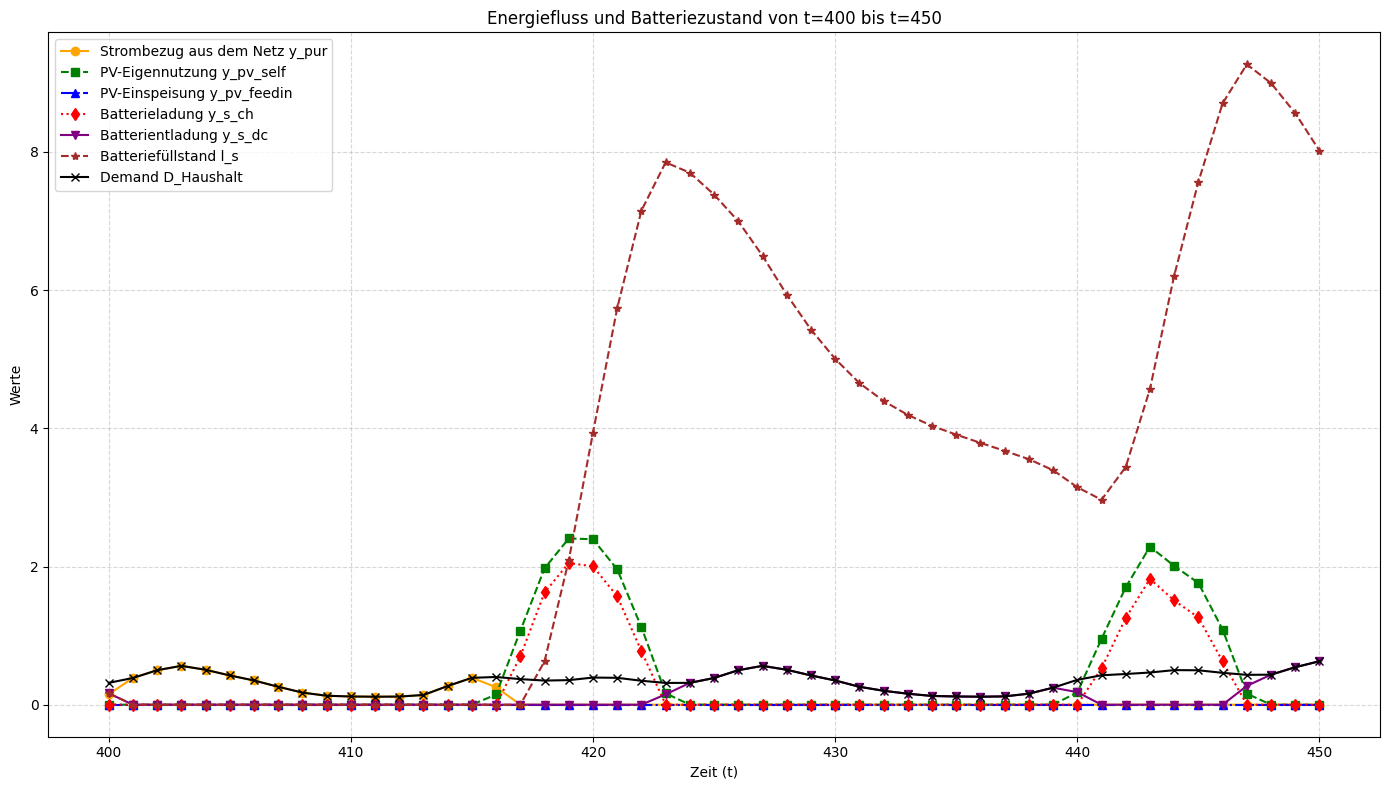

In [714]:
# Werte extrahieren
y_pur_values = [y_pur[t].varValue for t in range(T)]
y_pv_self_values = [y_pv_self[t].varValue for t in range(T)]
y_pv_feedin_values = [y_pv_feedin[t].varValue for t in range(T)]
y_s_ch_values = [y_s_ch[t].varValue for t in range(T)]
y_s_dc_values = [y_s_dc[t].varValue for t in range(T)]
l_s_values = [l_s[t].varValue for t in range(T)]
time_steps = list(range(T))

# Definiere den Bereich, den du plotten möchtest
start_t = 400
end_t = 450

# Slice die Daten für den gewünschten Bereich
sliced_time = time_steps[start_t:end_t+1]
sliced_y_pur = y_pur_values[start_t:end_t+1]
sliced_y_pv_self = y_pv_self_values[start_t:end_t+1]
sliced_y_pv_feedin = y_pv_feedin_values[start_t:end_t+1]
sliced_y_s_ch = y_s_ch_values[start_t:end_t+1]
sliced_y_s_dc = y_s_dc_values[start_t:end_t+1]
sliced_l_s = l_s_values[start_t:end_t+1]
sliced_demand = D_Haushalt[start_t:end_t+1]

# Plot erstellen
plt.figure(figsize=(14, 8))

# Strombezug aus dem Netz
plt.plot(sliced_time, sliced_y_pur, marker='o', linestyle='-', color='orange', label='Strombezug aus dem Netz y_pur')
# PV-Eigennutzung
plt.plot(sliced_time, sliced_y_pv_self, marker='s', linestyle='--', color='green', label='PV-Eigennutzung y_pv_self')
# PV-Einspeisung
plt.plot(sliced_time, sliced_y_pv_feedin, marker='^', linestyle='-.', color='blue', label='PV-Einspeisung y_pv_feedin')
# Batterieladung
plt.plot(sliced_time, sliced_y_s_ch, marker='d', linestyle=':', color='red', label='Batterieladung y_s_ch')
# Batterientladung
plt.plot(sliced_time, sliced_y_s_dc, marker='v', linestyle='-', color='purple', label='Batterientladung y_s_dc')
# Batteriefüllstand
plt.plot(sliced_time, sliced_l_s, marker='*', linestyle='--', color='brown', label='Batteriefüllstand l_s')
# Demand hinzufügen
plt.plot(sliced_time, sliced_demand, marker='x', linestyle='-', color='black', label='Demand D_Haushalt')

# Achsenbeschriftungen und Titel
plt.xlabel('Zeit (t)')
plt.ylabel('Werte')
plt.title(f'Energiefluss und Batteriezustand von t={start_t} bis t={end_t}')

# Legende
plt.legend()

# Gitter hinzufügen für bessere Lesbarkeit
plt.grid(True, linestyle='--', alpha=0.5)

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()

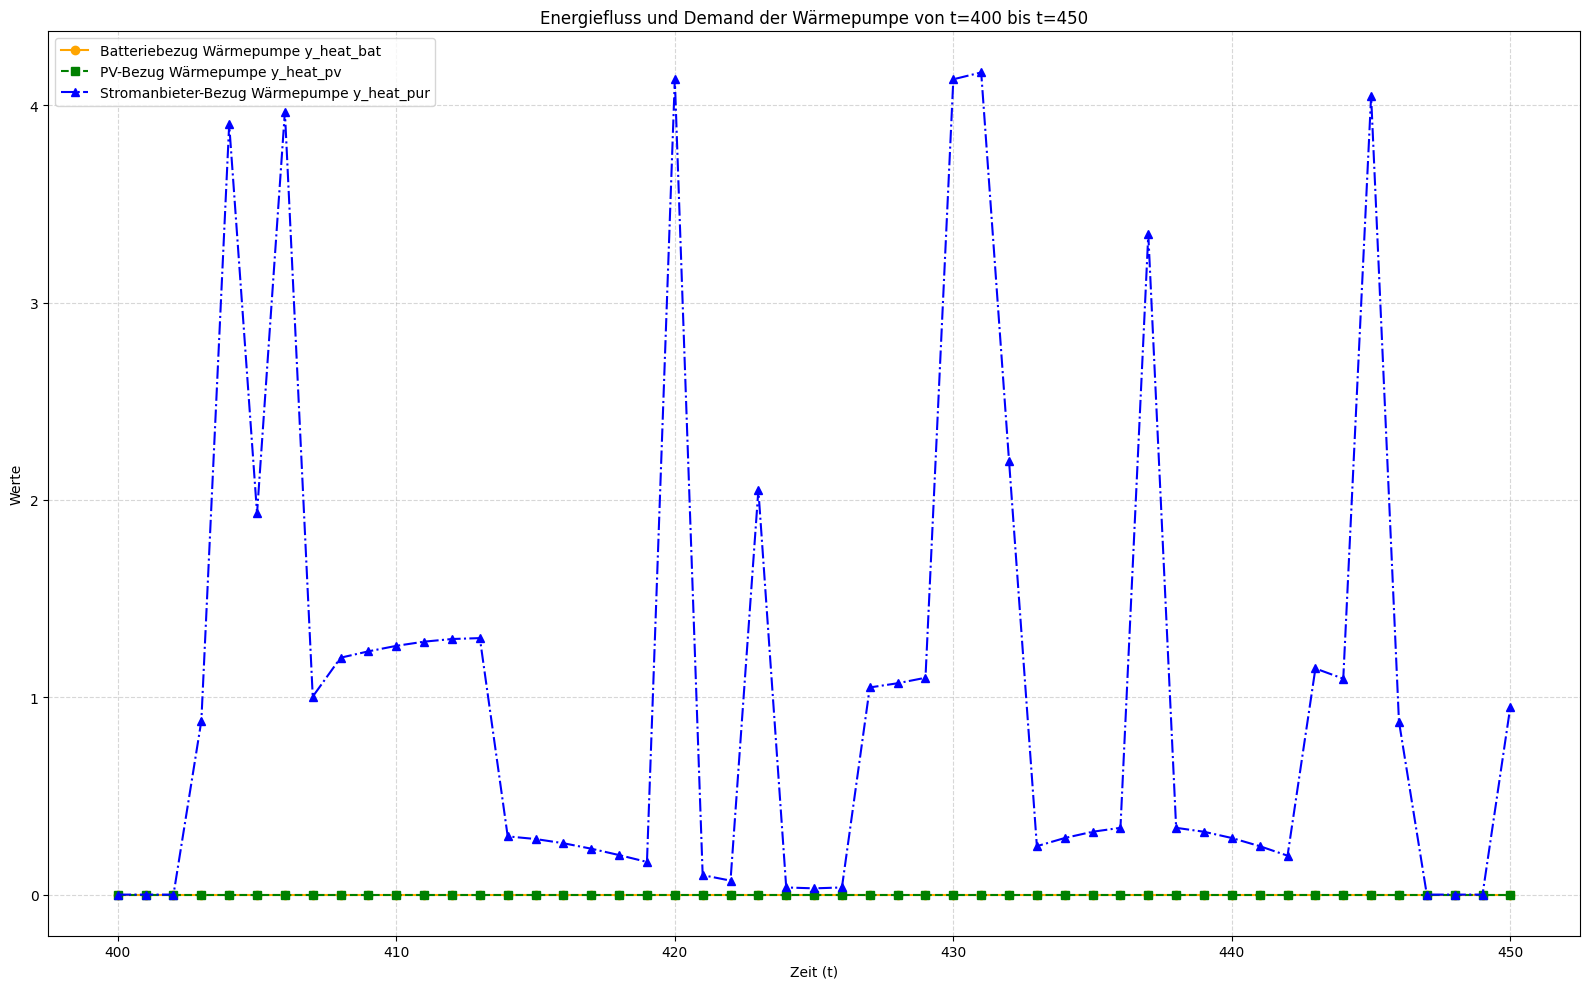

In [715]:
# Werte extrahieren
y_heat_bat_values = [y_heat_bat[t].varValue for t in range(T)]
y_heat_pv_values = [y_heat_pv[t].varValue for t in range(T)]
y_heat_pur_values = [y_heat_pur[t].varValue for t in range(T)]
time_steps = list(range(T))

# Definiere den Bereich, den du plotten möchtest
start_t = 400
end_t = 450

# Slice die Daten für den gewünschten Bereich
sliced_time = time_steps[start_t:end_t+1]
sliced_y_heat_bat = y_heat_bat_values[start_t:end_t+1]
sliced_y_heat_pv = y_heat_pv_values[start_t:end_t+1]
sliced_y_heat_pur = y_heat_pur_values[start_t:end_t+1]


# Plot erstellen
plt.figure(figsize=(16, 10))

# Batteriebezug der Wärmepumpe
plt.plot(sliced_time, sliced_y_heat_bat, marker='o', linestyle='-', color='orange', label='Batteriebezug Wärmepumpe y_heat_bat')
# PV-Bezug der Wärmepumpe
plt.plot(sliced_time, sliced_y_heat_pv, marker='s', linestyle='--', color='green', label='PV-Bezug Wärmepumpe y_heat_pv')
# Stromanbieter-Bezug der Wärmepumpe
plt.plot(sliced_time, sliced_y_heat_pur, marker='^', linestyle='-.', color='blue', label='Stromanbieter-Bezug Wärmepumpe y_heat_pur')

# Achsenbeschriftungen und Titel
plt.xlabel('Zeit (t)')
plt.ylabel('Werte')
plt.title(f'Energiefluss und Demand der Wärmepumpe von t={start_t} bis t={end_t}')

# Legende
plt.legend()

# Gitter hinzufügen für bessere Lesbarkeit
plt.grid(True, linestyle='--', alpha=0.5)

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()


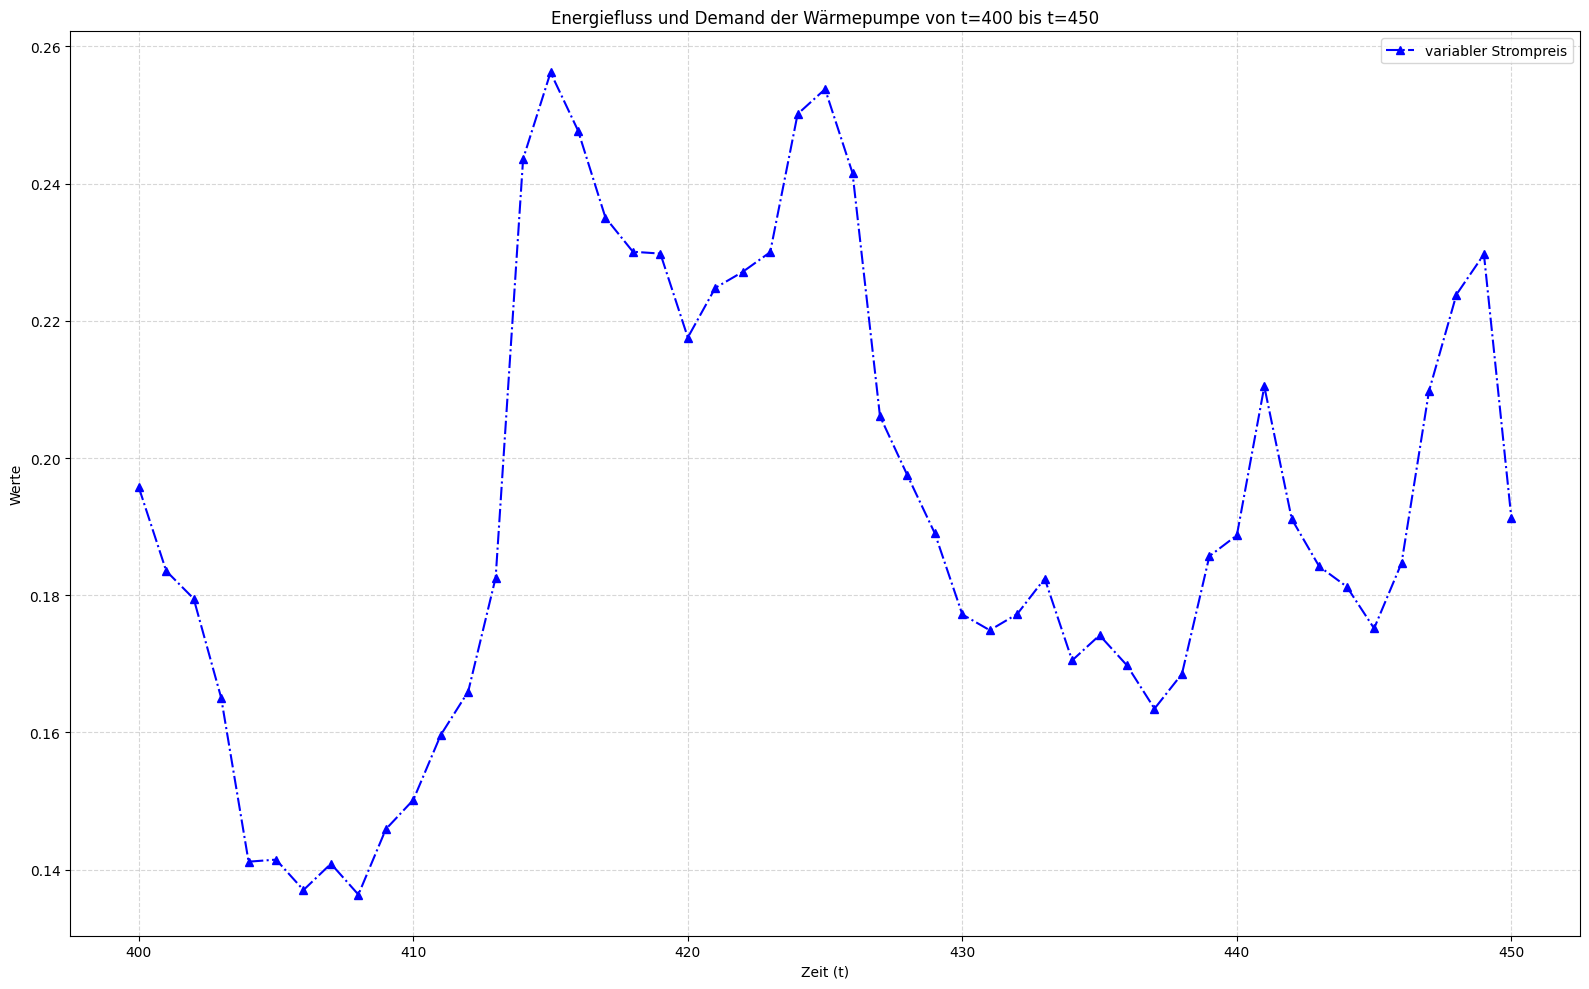

In [716]:
sliced_strompreis = Strompreise[start_t:end_t+1]

# Plot erstellen
plt.figure(figsize=(16, 10))

plt.plot(sliced_time, sliced_strompreis , marker='^', linestyle='-.', color='blue', label='variabler Strompreis')

# Achsenbeschriftungen und Titel
plt.xlabel('Zeit (t)')
plt.ylabel('Werte')
plt.title(f'Energiefluss und Demand der Wärmepumpe von t={start_t} bis t={end_t}')

# Legende
plt.legend()

# Gitter hinzufügen für bessere Lesbarkeit
plt.grid(True, linestyle='--', alpha=0.5)

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()

Über den gesamten Zeitverlauf wird nie Energie aus der Batterie für den Betrieb der Wärmepumpe entnommen. Dies ist die optimale Lösung und lässt sich durch die zwei verschiedenen Stromtarife erklären. Der variable Stromtarif scheint zu jedem Zeitpunkt günstiger zu sein, als der Strombezug im Basismodell. Deshalb ist es immer besser den Strombedarf der Wärmepumpe mit dem variablen Stromtarif zu decken, damit der Haushalt die volle Batterieelektrizität nutzen kann, um den Strombezug über den teuren Stromtarif zu meiden.

In [718]:
#Mini-Exkurs Lineare Algebra / Veranschaulichung des Problems 
print("Modelldimensionen: " + str(len(model.constraints)) + " x "+ str(len(model.variables())))
print("------------------")
print("Anzahl der Constraints (m):", len(model.constraints))
print("Anzahl der Variablen (n):", len(model.variables()))

Modelldimensionen: 52560 x 113880
------------------
Anzahl der Constraints (m): 52560
Anzahl der Variablen (n): 113880


# Matrixdarstellung

## Der Solver stellt eine Matrix der Dimension MxN auf.
-
- M: Anzahl der Nebenbedingungen (6 Nebenbedingung * 8760 Zeiteinheiten = 52560 Nebenbedingungen)
- N: Anzahl der Variablen (13 Variablen * 8760 Zeiteinheiten = 113880 Variablen)


\
\begin{aligned}
A_{MxN} &=
  \begin{pmatrix}
    a_{1,1} & a_{1,2} & a_{1,3} & \cdots & a_{1,N} \\
    a_{2,1} & a_{2,2} & a_{2,3} & \cdots & a_{2,N} \\
    a_{3,1} & a_{3,2} & a_{3,3} & \cdots & a_{3,N} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    a_{M,1} & a_{M,2} & a_{M,3} & \cdots & a_{M,N} \\
  \end{pmatrix}
\end{aligned}









In [719]:
#Amortisationsdauer der Wärmepumpe alleine
tag_kosten_pumpe_only = sum(d * preis for preis in strompreise)/4

tägliche_ersparnisse = jahresrechnung_heizkosten_vor_pumpe/365 - tag_kosten_pumpe_only

print("Average cost for heating before: ", jahresrechnung_heizkosten_vor_pumpe/365)
print("Cost with WP: ",tag_kosten_pumpe_only)
print("Ersparnisse pro Tag: ", tägliche_ersparnisse)
print("Average savings in %: ", tägliche_ersparnisse/(jahresrechnung_heizkosten_vor_pumpe/365)*100)
print("Amortisationsdauer in Jahren: ", anschaffunskosten_pumpe/tägliche_ersparnisse/365)

NameError: name 'strompreise' is not defined

In [82]:
#Amortisationsdauer des Wärmespeichers

# Optimalen Wert der Zielfunktion in einer Variablen speichern
optimal_value = value(model.objective)/4


print("Daily cost with pufferspeicher", optimal_value)
print("Daily cost without pufferspeicher", tag_kosten_pumpe_only)

ersparnisse = tag_kosten_pumpe_only - optimal_value
tage_bis_gelohnt = anschaffungskosten_speicher/ersparnisse

print("Gespart pro Tag in Euro: ", ersparnisse)
print("Amortisationsdauer basierend auf den letzten 24h in Jahren: ", tage_bis_gelohnt/365)

Daily cost with pufferspeicher 8152.534776614993


NameError: name 'tag_kosten_pumpe_only' is not defined

In [83]:
#reale Schätzungen für Amortisationsdauer
#hier reale schätzung, durch vorfaktor basierend auf jahreszeit (da nur 1d wetter daten vorhanden)